In [1]:
using TVC, DifferentialEquations, SCPToolbox, Plots, Revise, LinearAlgebra, Parameters

# Specify Parameters

In [2]:
veh = RocketParameters()
atmos = Atmosphere()
traj = RocketTrajectoryParameters();

mdl = RocketProblem(veh, atmos, traj)

RocketProblem
  veh: RocketParameters{Float64, Diagonal{Float64, Vector{Float64}}}
  atmos: Atmosphere
  traj: RocketTrajectoryParameters{Float64}


In [3]:
servoΔt = 0.02 # Servo step rate
x_0 = [traj.r0; traj.v0; traj.q0; traj.ω0][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]];

# Solve Optimal Trajectory

In [4]:
solution = solveProblem(mdl);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 2e-01 | 0e+00 | 8e-10 | 1.01e+01  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.09  | 0.40  | 0.16 


2  | ALMOST_O | 3e-03 | 0e+00 | 2e-09 | 3.93e-01  | 96.12     | 1e-02 | 4e-02 | 3e-02 | 4e-02 | T   | 0.02  | 0.04  | 0.03 


3  | ALMOST_O | 5e-05 | 0e+00 | 1e-07 | 2.97e-01  | 24.50     | 2e-03 | 1e-01 | 7e-04 | 2e-03 | T   | 0.10  | 0.11  | 0.00 


4  | ALMOST_O | 2e-05 | 0e+00 | 1e-07 | 2.94e-01  | 0.98      | 1e-03 | 5e-02 | 4e-05 | 1e-03 | T   | 0.01  | 0.06  | 0.00 


5  | ALMOST_O | 4e-06 | 0e+00 | 6e-08 | 2.93e-01  | 0.15      | 1e-03 | 4e-02 | 3e-05 | 1e-03 | T   | 0.02  | 0.04  | 0.00 


6  | ALMOST_O | 9e-07 | 0e+00 | 1e-08 | 2.93e-01  | 0.08      | 5e-04 | 2e-02 | 1e-05 | 5e-04 | T   | 0.01  | 0.02  | 0.00 


# Specify Controller

In [5]:
function control(x, p, t, servoΔt)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    td = tₘ - tₘ % servoΔt

    if 0 ≤ tₘ ≤ veh.BurnTime
        desired_tvc = sample(sol.xc, td / veh.BurnTime)[veh.id_T]
        desired_roll = sample(sol.uc, td / veh.BurnTime)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

function control(x, p, t)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    if 0 ≤ tₘ ≤ veh.BurnTime
        desired_tvc = sample(sol.xc, tₘ / veh.BurnTime)[veh.id_T]
        desired_roll = sample(sol.uc, tₘ / veh.BurnTime)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

control (generic function with 2 methods)

In [6]:
function control(x, p, t, servoΔt)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    td = tₘ - tₘ % servoΔt

    if p.traj.t0 ≤ tₘ ≤ veh.BurnTime
        time = (td - p.traj.t0) / (veh.BurnTime - p.traj.t0)
        desired_tvc = sample(sol.xc, time)[veh.id_T]
        desired_roll = sample(sol.uc, time)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

function control(x, p, t)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution

    if p.traj.t0 ≤ tₘ ≤ veh.BurnTime
        time = (tₘ - p.traj.t0) / (veh.BurnTime - p.traj.t0)
        desired_tvc = sample(sol.xc, time)[veh.id_T]
        desired_roll = sample(sol.uc, time)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

control (generic function with 2 methods)

In [7]:
function Actuator(x, p, t, desired_tvc, desired_roll) # Model of TVC
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)

    Thrust = desired_tvc * veh.Thrust(tₘ)
    torque = veh.MomentArm(tₘ) × Thrust + [0; 0; desired_roll]
    
    return (force=Thrust, torque=torque)
end

Actuator (generic function with 1 method)

# Simulate controller using optimal trajectory

In [8]:
using Parameters

@with_kw struct ODEParameters{R, V}
    veh::RocketParameters = RocketParameters()
    atmos::Atmosphere = Atmosphere()
    traj::RocketTrajectoryParameters = RocketTrajectoryParameters()

    Aero::Bool = false
    wind::V = zeros(3)

    ground::Bool = false

    solution::SCPSolution

    MotorIgnitionTime::R = 0.0
    Control = zeros(3)
end

ODEParameters

## Continuous Controller

In [9]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

if traj.MotorFired == true
    MotorIgnitionTime = 0.
end

tspan = (traj.t0, traj.t0 + veh.BurnTime + MotorIgnitionTime + 10.0)

p = ODEParameters(veh=veh, atmos=atmos, traj=traj, Aero=false, solution=solution, MotorIgnitionTime=MotorIgnitionTime, Control=(x, p, t) -> control(x, p, t))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb);

1.3244500627024687
3.44999136590439

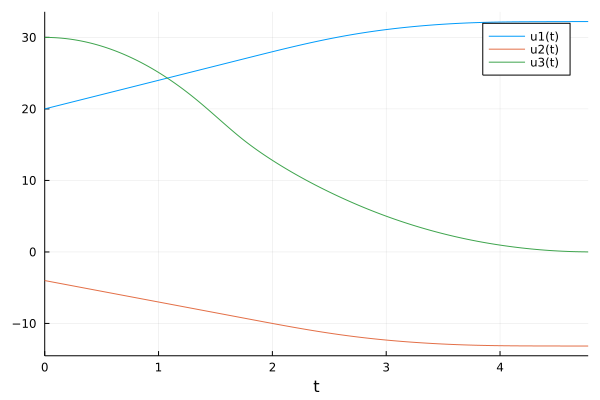

In [10]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)
plot(sol, vars=1:3)

## Discrete Controller

In [11]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = ODEParameters(veh=veh, atmos=atmos, traj=traj, solution=solution, MotorIgnitionTime=MotorIgnitionTime, Control=(x, p, t) -> control(x, p, t, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

saved_values = SavedValues(Float64, AbstractVector{Float64})
scb = SavingCallback((x, t, integrator) -> [integrator.p.Control(x, integrator.p, t).force; integrator.p.Control(x, integrator.p, t).torque[3]], saved_values, save_everystep = true)

cbs = CallbackSet(cb, scb)

sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12, callback=cbs);

In [12]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

1.3244500627024687
3.418443808751916


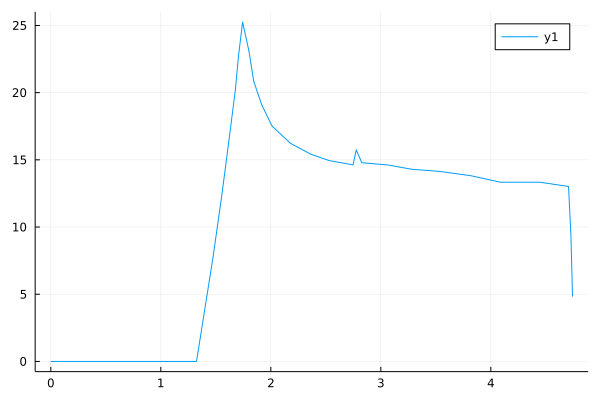

In [13]:
plot(saved_values.t, reduce(hcat, saved_values.saveval)[3, :])
# plot!(saved_values.t, mapreduce(t -> control(x, p, t, servoΔt), hcat, saved_values.t)[1, :])
# plot!(saved_values.t, mapreduce(t -> control(motorTime(t, MotorIgnitionTime), veh, solution), hcat, saved_values.t)[1, :])

# MPC Controller

In [14]:
using Printf

function mpc!(integrator)
    veh = integrator.p.veh
    atmos = integrator.p.atmos

    x = integrator.u

    r = x[veh.id_r]
    v = x[veh.id_v]
    quat = x[veh.id_quat]
    ω = x[veh.id_ω]

    if integrator.t >= integrator.p.MotorIgnitionTime[]
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=quat, ω0=ω, t0=integrator.t - integrator.p.MotorIgnitionTime[], MotorFired=true)
    else
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=quat, ω0=ω)
    end

    mdl = RocketProblem(veh, atmos, traj)
    tmpSolution = solveProblem(mdl)

    println(tmpSolution.status)

    println("\n", traj, "\n")

    if tmpSolution.status == @sprintf("%s", SCP_SOLVED)
        integrator.p.solution[] = tmpSolution
        
        if !traj.MotorFired
            integrator.p.MotorIgnitionTime[] = integrator.t + integrator.p.solution[].p[veh.id_tcoast]
        end
    end

    println(integrator.t + integrator.p.solution[].p[veh.id_tcoast])
end

mpccb = PeriodicCallback(mpc!, 1.);

In [15]:
import TVC: motorTime
function motorTime(t, MotorIgnitionTime)
    return t - MotorIgnitionTime[]
end


motorTime (generic function with 2 methods)

In [16]:
function control(x, p, t, servoΔt)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)
    sol = p.solution[]

    td = tₘ - tₘ % servoΔt

    if 0 ≤ tₘ ≤ veh.BurnTime
        desired_tvc = sample(sol.xc, td / veh.BurnTime)[veh.id_T]
        desired_roll = sample(sol.uc, td / veh.BurnTime)[veh.id_roll]
    else
        desired_tvc = zeros(3)
        desired_roll = 0.
    end

    return Actuator(x, p, t, desired_tvc, desired_roll)
end

control (generic function with 2 methods)

In [17]:
@with_kw struct ODEParametersTest{R, S, V}
    veh::RocketParameters = RocketParameters()
    atmos::Atmosphere = Atmosphere()
    traj::RocketTrajectoryParameters = RocketTrajectoryParameters()

    Aero::Bool = true
    wind::V = zeros(3)

    solution::S

    MotorIgnitionTime::R = 0.0
    Control = zeros(3)
end

ODEParametersTest

In [18]:
MotorIgnitionTime = Ref(solution.p[veh.id_tcoast])

tspan = (0., solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)

test = Ref(solution)
p = ODEParametersTest(veh=veh, atmos=atmos, traj=traj, Aero=true, solution=test, MotorIgnitionTime=MotorIgnitionTime, Control=(x, p, t) -> control(x, p, t, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

saved_values = SavedValues(Float64, Float64)
scb = SavingCallback((u, t, integrator) -> integrator.p.MotorIgnitionTime[], saved_values, save_everystep = true)

cbs = CallbackSet(cb, mpccb, scb);
# cbs = CallbackSet(cb, scb);

In [19]:
sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

ErrorException: type ODEParametersTest has no field ground

1.3244500627024687
3.418443808751916


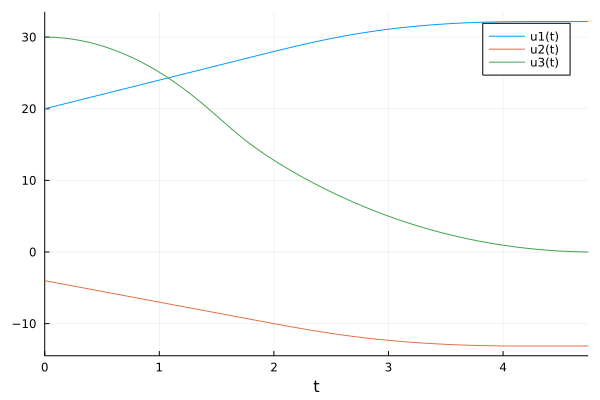

In [20]:
println(sol.prob.p.MotorIgnitionTime[])
println(sol.t[end] - sol.prob.p.MotorIgnitionTime[])
Plots.plot(sol, vars=1:3)

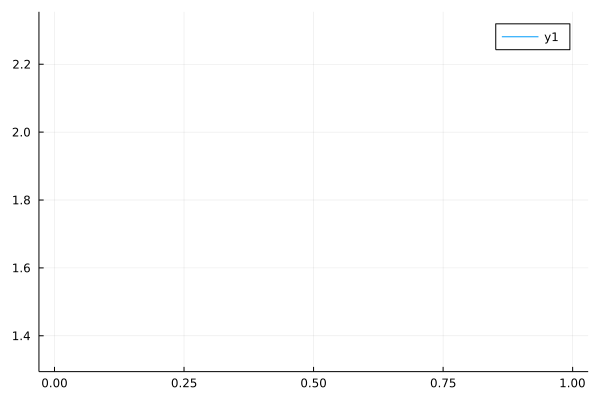

In [21]:
plot(saved_values.t, saved_values.saveval)